In [1]:
import torch

### Load Analyzed Games

In [2]:
# position_type = "bitboards"           # 44.00% accuracy
# position_type = "bitboards_mirrors"   # 44.67% accuracy
# position_type = "boards"              # 41.53% accuracy
position_type = "boards_mirrors"      # 43.93% accuracy

In [3]:
dataset_path = "../../datasets/"
positions, elo1 = torch.load(dataset_path + f"positions/all_{position_type}_0-2000.pt")


game_analysis1 = torch.load(dataset_path + "analysis/all_analysis_0-500.pt")
game_analysis2 = torch.load(dataset_path + "analysis/all_analysis_500-1000.pt")
game_analysis3 = torch.load(dataset_path + "analysis/all_analysis_1000-1500.pt")
game_analysis4 = torch.load(dataset_path + "analysis/all_analysis_1500-2000.pt")

analysis = []
elo2 = []
for i in range(10):
    analysis += game_analysis1[0][i * 500: (i + 1) * 500] + game_analysis2[0][i * 500: (
        i + 1) * 500] + game_analysis3[0][i * 500: (i + 1) * 500] + game_analysis4[0][i * 500: (i + 1) * 500]
    elo2 += game_analysis1[1][i * 500: (i + 1) * 500] + game_analysis2[1][i * 500: (
        i + 1) * 500] + game_analysis3[1][i * 500: (i + 1) * 500] + game_analysis4[1][i * 500: (i + 1) * 500]

print(len(analysis))
print(len(positions))

for i, (pos, anal) in enumerate(zip(positions, analysis)):
    assert pos.size()[1] == anal.size()[1]

for i, (e1, e2) in enumerate(zip(elo1, elo2)):
    assert all(e == l for e, l in zip(e1, e2))

20000
20000


In [4]:
print(f"Number of games: {len(positions)}, {len(analysis)}, {len(elo1)}, {len(elo2)}")
print(f"Moves of first game: {len(positions[0][0])}")
print(f"Input size: {len(positions[0][0][0]) + len(analysis[0][0][0])}")

input_size = len(positions[0][0][0]) + len(analysis[0][0][0])

Number of games: 20000, 20000, 20000, 20000
Moves of first game: 59
Input size: 82


### Define the Model

In [5]:
import sys
sys.path.append("..")

from lstm_network import initialize_model

In [6]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")          # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu") 

Using GPU: NVIDIA GeForce MX230


In [7]:
hidden_size = 128
num_layers = 2
learning_rate = 0.001
lstm_model, optimizer = initialize_model(input_size, hidden_size, num_layers, device, learning_rate, num_classes=10)

### Modify the dataset for training

In [8]:
# These are the rating ranges the model will try to classify
rating_ranges = [
    (200, 1000), (1000, 1200), (1200, 1400), (1400, 1600), (1600, 1800),
    (1800, 2000), (2000, 2200), (2200, 2400), (2400, 2600), (2600, 3400)
]

# Suppose the elo of a player is a normal distribution with mean = elo and stdv = 100
# calculate the probability of the player being in each range by integrating the normal distribution in that range
def calculate_elo_range(true_elo):
    import scipy.stats as st

    stdv = 200
    return torch.stack([
            torch.tensor([st.norm.cdf(r[1], loc=elo, scale=stdv)
            - st.norm.cdf(r[0], loc=elo, scale=stdv) for r in rating_ranges])
            for elo in true_elo
        ])

# Based on probability distribution per rating range
# Try to guess the mean elo of the player
def guess_elo_range(elo_range):
    s = 0
    for r, probability in zip(rating_ranges, elo_range):
        s += probability * (r[0] + r[1]) / 2

    return int(s / sum(elo_range))

In [9]:
import random

dataset = [
    (torch.cat((game_position, game_analysis), dim=-1), game_elo) 
    for game_position, game_analysis, game_elo, elo_check in zip(positions, analysis, elo1, elo2) 
    if len(game_position[0]) == len(game_analysis[0])
]

total_games = len(dataset)
print(f"Total games: {total_games}")

classes = len(rating_ranges)

# Spilt into train and test data
test_games = int(total_games * 0.15)

random.shuffle(dataset)

x_train = [game.to(device) for game, _ in dataset[:-test_games]]
y_train = [calculate_elo_range(elo).to(device) for _, elo in dataset[:-test_games]]
x_test  = [game.to(device) for game, _ in dataset[-test_games:]]
y_test  = [calculate_elo_range(elo).to(device) for _, elo in dataset[-test_games:]]

Total games: 20000


### Train the model

In [10]:
from lstm_network import train_model

In [11]:
# CrossEntropyLoss is commonly used for classification problems
# Since this is technically not a classification problem, I'm not sure it's the best choice 
loss_func = torch.nn.CrossEntropyLoss()

loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=5)

Epoch: 1, Validation Loss: 2.0103728187906076
Epoch: 2, Validation Loss: 1.93216710591902
Epoch: 3, Validation Loss: 1.9272946033296188
Epoch: 4, Validation Loss: 1.9185158697818439
Epoch: 5, Validation Loss: 1.8922168461844662


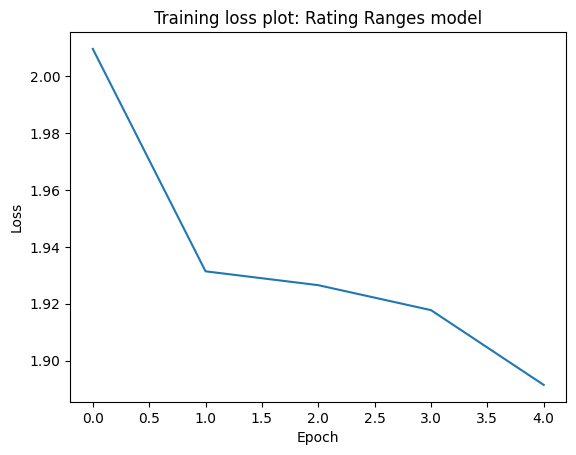

In [13]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
# Should be a downward trend
plt.plot(loss_graph)
plt.title("Training loss plot: Rating Ranges model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# With 10 classes a random model would have -log(1/10) = 2.3 loss

plt.savefig("../loss_plots/rating_ranges_loss.png")

### Test how the model predicts new data

The predictions of the model are compared to a random guessing and a constant guessing model

In [14]:
predictions = []
real_values = []
c = 0

for x, y in zip(x_test, y_test):
    # Predict for white and black
    out = lstm_model(x[0], train=False)[0] # [0] because model returns (output, (hidden_state, cell_state))
    
    predictions.append(guess_elo_range(out[0])) # [0] because out is a batch
    real_values.append(guess_elo_range(y[0]))
    
    # If the model gave the correct range the maximum probability we can count it as a correct guess
    if (out[0].argmax() == y[0].argmax()): 
        c += 1

    out = lstm_model(x[1], train=False)[0]
    
    predictions.append(guess_elo_range(out[0]))
    real_values.append(guess_elo_range(y[1]))

    if out[0].argmax() == y[1].argmax():
        c += 1
    
print(f"Correct range guesses: {c} / {len(x_test) * 2} = {c / (len(x_test) * 2):.2f}")

Correct range guesses: 1764 / 6000 = 0.29


In [15]:
differences = [abs(p - r) for p, r in zip(predictions, real_values)]
sorted_differences = sorted(differences)

ninetieth_percentile = int(len(sorted_differences) * 0.90)
diff = round(sorted_differences[ninetieth_percentile], 2)
print(f"90% of the predictions are within {diff} elo points of the real value")

90% of the predictions are within 540 elo points of the real value


Correlation coefficient: 0.8141242343064846


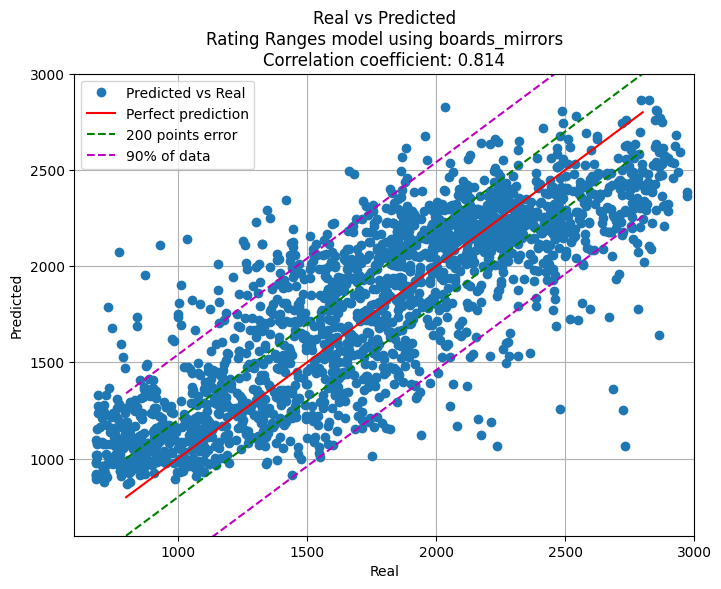

In [16]:
fig = plt.figure(figsize=(8, 6))
axs = fig.add_subplot(111)


axs.plot(real_values[:2000], predictions[:2000], 'o', label="Predicted vs Real")

axs.plot([800, 2800], [800, 2800], 'r-', label="Perfect prediction") # the closer to this line the better
axs.plot([800, 2800], [600, 2600], 'g--', label="200 points error")
axs.plot([800, 2800], [1000, 3000], 'g--', label="") # these two lines show acceptable error (200 elo)

axs.plot([800, 2800], [800 + diff, 2800 + diff], 'm--', label="90% of data")
axs.plot([800, 2800], [800 - diff, 2800 - diff], 'm--', label="") # these two lines encompass 90% of the data


from scipy.stats import pearsonr
corr_coeff, _p = pearsonr(real_values, predictions)
print(f"Correlation coefficient: {corr_coeff}")

axs.set_title(f"Real vs Predicted\nRating Ranges model using {position_type}\nCorrelation coefficient: {corr_coeff:.3f}")

axs.set_xlabel("Real")
axs.set_ylabel("Predicted")

axs.set_xlim(600, 3000)
axs.set_ylim(600, 3000)

axs.grid()
axs.legend()

fig.savefig(f"../loss_plots/rating_ranges_{position_type}_predictions.png")
plt.show()

In [17]:
def rate_predictions(predictions, real_values):
    correct = 0
    diff = 0
    high_elo = [0, 0]
    low_elo = [0, 0]
    real_high = 0
    real_low = 0
    # We give the model a leeway of +-200 points
    # More leeway = more accuracy
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
        diff += abs(prediction - real)
        if real > 1700:
            high_elo[0] += 1
            high_elo[1] += prediction
            real_high += real
        if real <= 1700:
            low_elo[0] += 1
            low_elo[1] += prediction
            real_low += real
    return correct / len(predictions), correct, diff/len(predictions), high_elo[1]/high_elo[0], low_elo[1]/low_elo[0], real_high/high_elo[0], real_low/low_elo[0]

percentage, correct, diff, high_predictions, low_predictions, real_high, real_low = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")
print(f"Average prediction for high elo games: {high_predictions:.2f} elo. Real average: {real_high:.2f} elo")
print(f"Average prediction for low elo games: {low_predictions:.2f} elo. Real average: {real_low:.2f} elo")


Correctly predicted 46.52% of games
2791 out of 6000 predictions
Average difference: 262.86 elo
Average prediction for high elo games: 2104.84 elo. Real average: 2203.98 elo
Average prediction for low elo games: 1410.37 elo. Real average: 1235.30 elo


In [24]:
# Compare the model to a random guess. Random values for each rating range
import random

random_predictions = [guess_elo_range([random.random() for _ in range(classes)]) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(random_predictions)} predictions") 
print(f"Average difference: {diff:.2f} elo")  

Correctly guessed at random 23.12% of games
1387 out of 6000 predictions
Average difference: 492.34 elo


In [27]:
# Compare the model to a constant guess. Equal probability for each rating range
# Outputs a guess somewhere in the middle

constant_predictions = [guess_elo_range([1/classes for _ in range(classes)]) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(constant_predictions, real_values)
print(f"Correctly guessed with constant guess {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(constant_predictions)} predictions")  
print(f"Average difference: {diff:.2f} elo") 

Correctly guessed with constant guess 22.25% of games
1335 out of 6000 predictions
Average difference: 481.68 elo


In [36]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), f"{position_type}.pt")